<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/ICP_driftingipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt

def apply_transform(points, dx, dy, dangle):
    transformed = points.copy()

    angle_rad = np.radians(dangle)
    cos_a = math.cos(angle_rad)
    sin_a = math.sin(angle_rad)

    x_old = transformed[:, 0].copy()
    y_old = transformed[:, 1].copy()
    transformed[:, 0] = x_old * cos_a - y_old * sin_a
    transformed[:, 1] = x_old * sin_a + y_old * cos_a

    transformed[:, 0] += dx
    transformed[:, 1] += dy

    return transformed


# Change points to form the perimeter of a rectangle (non-square)
x_min, y_min = -7, -5 # Wider rectangle
x_max, y_max = 7, 5

points_list = []

# Define different number of points for horizontal and vertical edges
# This ensures different density along length and width
num_points_horizontal_edge = 30 # Points for top and bottom edges
num_points_vertical_edge = 20   # Points for left and right edges

# Bottom edge
x_coords_bottom = np.linspace(x_min, x_max, num_points_horizontal_edge + 1, endpoint=True)[:-1]
points_list.extend([[x, y_min] for x in x_coords_bottom])

# Right edge
y_coords_right = np.linspace(y_min, y_max, num_points_vertical_edge + 1, endpoint=True)[:-1]
points_list.extend([[x_max, y] for y in y_coords_right])

# Top edge
x_coords_top = np.linspace(x_max, x_min, num_points_horizontal_edge + 1, endpoint=True)[:-1]
points_list.extend([[x, y_max] for x in x_coords_top])

# Left edge
y_coords_left = np.linspace(y_max, y_min, num_points_vertical_edge + 1, endpoint=True)[:-1]
points_list.extend([[x_min, y] for y in y_coords_left])

points = np.array(points_list)

# The total number of points will be (num_points_horizontal_edge + num_points_vertical_edge) * 2
# In this case, (30 + 20) * 2 = 100 points

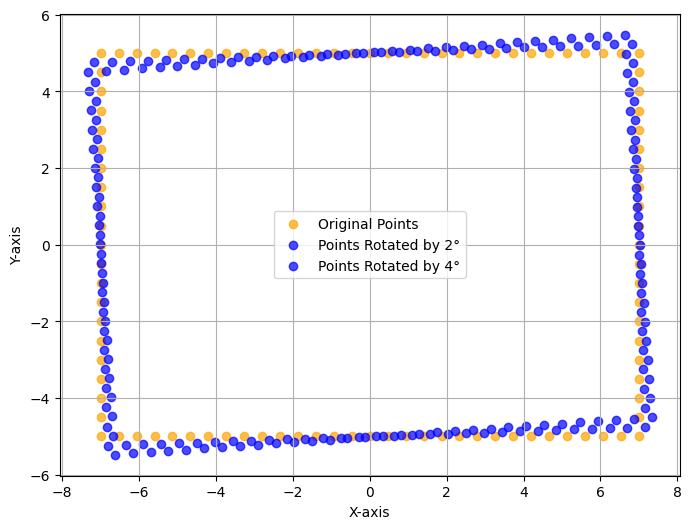

In [111]:
transformed_points_2deg = apply_transform(points, dx=0, dy=0, dangle=2)
transformed_points_4deg = apply_transform(transformed_points_2deg, dx=0, dy=0, dangle=2)

plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], color='orange', label='Original Points', alpha=0.7)
plt.scatter(transformed_points_2deg[:, 0], transformed_points_2deg[:, 1], color='blue', label='Points Rotated by 2°', alpha=0.7)
plt.scatter(transformed_points_4deg[:, 0], transformed_points_4deg[:, 1], color='blue', label='Points Rotated by 4°', alpha=0.7)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.legend()
plt.show()

In [112]:
from scipy.spatial import KDTree
import numpy as np

def compute_transformation(current, base, init_angle, constants):
    ITERATIONS = constants['ITERATIONS']
    current_transformed = apply_transform(current, 0, 0, init_angle)
    tree_base = KDTree(base)
    best_dx = best_dy = 0.0
    best_error = float('inf')
    total_dx = total_dy = 0.0
    for iteration in range(ITERATIONS):
        distances, indices = tree_base.query(current_transformed)
        dx = np.mean(base[indices, 0] - current_transformed[:, 0])
        dy = np.mean(base[indices, 1] - current_transformed[:, 1])
        current_transformed = apply_transform(current_transformed, dx, dy, 0)
        total_dx += dx
        total_dy += dy
        error = np.mean(distances)
        if error < best_error:
            best_error = error
            best_dx = total_dx
            best_dy = total_dy
        if abs(dx) < 0.01 and abs(dy) < 0.01:
            break
    return best_dx, best_dy, best_error

def find_best_transform(current, base, constants):
    ANGLE_RANGE = constants['ANGLE_RANGE']
    COARSE_ANGLE_STEP = constants['COARSE_ANGLE_STEP']
    FINE_ANGLE_STEP = constants['FINE_ANGLE_STEP']
    angles_coarse = np.arange(-ANGLE_RANGE, ANGLE_RANGE + COARSE_ANGLE_STEP, COARSE_ANGLE_STEP)
    best_dx, best_dy, best_angle, best_error = 0.0, 0.0, 0.0, float('inf')
    for angle in angles_coarse:
        dx, dy, error = compute_transformation(current, base, angle, constants)
        if error < best_error:
            best_error = error
            best_dx = dx
            best_dy = dy
            best_angle = angle
    fine_search_range = COARSE_ANGLE_STEP - 1
    angles_fine = np.arange(best_angle - fine_search_range,
                           best_angle + fine_search_range + FINE_ANGLE_STEP,
                           FINE_ANGLE_STEP)
    for angle in angles_fine:
        dx, dy, error = compute_transformation(current, base, angle, constants)
        if error < best_error:
            best_error = error
            best_dx = dx
            best_dy = dy
            best_angle = angle
    return best_dx, best_dy, best_angle, best_error


# Define constants for the transformation search
constants = {
    'ITERATIONS': 100,
    'ANGLE_RANGE': 90,
    'COARSE_ANGLE_STEP': 5,
    'FINE_ANGLE_STEP': 0.5
}

# Calculate the transformation
best_dx, best_dy, best_angle, best_error = find_best_transform(points, transformed_points_2deg, constants)

print(f"Calculated Transformation:")
print(f"  Translation X (dx): {best_dx:.4f}")
print(f"  Translation Y (dy): {best_dy:.4f}")
print(f"  Rotation Angle: {best_angle:.4f} degrees")
print(f"  Final Error: {best_error:.4f}")


best_dx, best_dy, best_angle, best_error = find_best_transform(transformed_points_2deg, transformed_points_4deg, constants)

print(f"Calculated Transformation:")
print(f"  Translation X (dx): {best_dx:.4f}")
print(f"  Translation Y (dy): {best_dy:.4f}")
print(f"  Rotation Angle: {best_angle:.4f} degrees")
print(f"  Final Error: {best_error:.4f}")

Calculated Transformation:
  Translation X (dx): 0.0000
  Translation Y (dy): 0.0000
  Rotation Angle: 2.0000 degrees
  Final Error: 0.0000
Calculated Transformation:
  Translation X (dx): 0.0000
  Translation Y (dy): 0.0000
  Rotation Angle: 2.0000 degrees
  Final Error: 0.0000
